In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Load ESC-50 metadata
esc50_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
esc50_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"

metadata = pd.read_csv(esc50_csv_path)

# Function to extract stacked features (LM + TZ)
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        # Ensure uniform size
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[1], axis=1)
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[0], axis=0)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[1], axis=1)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[0], axis=0)

        stacked_features = np.stack([mel_spec, tonnetz], axis=-1)
        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Prepare dataset
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_path = os.path.join(esc50_audio_dir, metadata.loc[i, "filename"])
    label = metadata.loc[i, "target"]

    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array([img for img in X if img is not None])
y = to_categorical(y, num_classes=50)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model
def create_cnn_model(input_shape, num_classes=50):
    model = Sequential([
        Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(32, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),

        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Train the CNN model
input_shape = (128, 128, 2)
num_classes = 50
model = create_cnn_model(input_shape, num_classes)

# Train model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Save trained model
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_TZ_ESC50.h5"
model.save(esc50_model_path)
print("ESC-50 pre-trained model saved successfully!")

 14%|█▍        | 286/2000 [01:20<07:04,  4.04it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [09:13<00:00,  3.61it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.0167 - loss: 3.9574 - val_accuracy: 0.0075 - val_loss: 3.9143
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.0165 - loss: 3.8706 - val_accuracy: 0.0475 - val_loss: 3.7935
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.0444 - loss: 3.6860 - val_accuracy: 0.0775 - val_loss: 3.5036
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.0916 - loss: 3.3600 - val_accuracy: 0.1725 - val_loss: 3.0926
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.1428 - loss: 3.0203 - val_accuracy: 0.2025 - val_loss: 2.7754
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.2469 - loss: 2.6921 - val_accuracy: 0.2675 - val_loss: 2.5925
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - accuracy: 0.3020 - loss: 2.4634 - val_accuracy: 0.3000 - val_loss: 2.4675
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.3460 - loss: 2.2462 - 

ESC-50 pre-trained model saved successfully!


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Sequential

# Load the pre-trained ESC-50 model for fine-tuning
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_TZ_ESC50.h5"
model = load_model(esc50_model_path)
print("Pre-trained ESC-50 model loaded successfully!")

# Load UrbanSound8K metadata
urbansound_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

metadata = pd.read_csv(urbansound_csv_path)

# Prepare UrbanSound8K dataset
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_name = metadata.loc[i, "slice_file_name"]
    folder = f"fold{metadata.loc[i, 'fold']}"
    file_path = os.path.join(urbansound_audio_dir, folder, file_name)
    label = metadata.loc[i, "classID"]

    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array([img for img in X if img is not None])
y = to_categorical(y, num_classes=10)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modify last layer to match UrbanSound8K's 10 classes
model.pop()
model.add(Dense(10, activation='softmax'))

# Recompile and fine-tune
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
report = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:", report)

# Save fine-tuned model
urbansound_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_UrbanSound8K.h5"
model.save(urbansound_model_path)
print("Fine-tuned UrbanSound8K model saved successfully!")


Pre-trained ESC-50 model loaded successfully!


  0%|          | 0/8732 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=876
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=438
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=219
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=110
  warnings.warn(
  0%|          | 9/8732 [00:02<38:28,  3.78it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=894
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=447

Error processing file /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold2/17307-1-0-0.wav: Audio buffer is not finite everywhere


 41%|████      | 3590/8732 [16:29<23:04,  3.71it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=989
  warnings.warn(
 41%|████      | 3595/8732 [16:30<22:35,  3.79it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=879
  warnings.warn(
 41%|████      | 3596/8732 [16:31<21:51,  3.92it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=905
  warnings.warn(
 41%|████      | 3599/8732 [16:31<21:49,  3.92it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=907
  warnings.warn(
 41%|████▏     | 3604/8732 [16:33<20:07,  4.25it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal o

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 340ms/step - accuracy: 0.3166 - loss: 2.1871 - val_accuracy: 0.5993 - val_loss: 1.1793
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 79s 330ms/step - accuracy: 0.5948 - loss: 1.1547 - val_accuracy: 0.6634 - val_loss: 1.0071
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 86s 347ms/step - accuracy: 0.6627 - loss: 0.9691 - val_accuracy: 0.6926 - val_loss: 0.9045
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 345ms/step - accuracy: 0.7076 - loss: 0.8537 - val_accuracy: 0.7167 - val_loss: 0.8321
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 339ms/step - accuracy: 0.7439 - loss: 0.7804 - val_accuracy: 0.7441 - val_loss: 0.7755
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 342ms/step - accuracy: 0.7606 - loss: 0.7259 - val_accuracy: 0.7556 - val_loss: 0.7356
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 83s 344ms/step - accuracy: 0.7856 - loss: 0.6610 - val_accuracy: 0.7562 - val_loss: 0.7161
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 341ms/step - accuracy: 0.7962 - loss: 0

Classification Report:               precision    recall  f1-score   support

           0     0.8491    0.9249    0.8854       213
           1     0.8333    0.8784    0.8553        74
           2     0.8308    0.8267    0.8288       202
           3     0.8660    0.8744    0.8702       207
           4     0.8894    0.8937    0.8916       207
           5     0.9326    0.9137    0.9231       197
           6     0.9571    0.9306    0.9437        72
           7     0.9263    0.9026    0.9143       195
           8     0.9241    0.8588    0.8902       170
           9     0.8510    0.8429    0.8469       210

    accuracy                         0.8821      1747
   macro avg     0.8860    0.8847    0.8849      1747
weighted avg     0.8831    0.8821    0.8822      1747

Fine-tuned UrbanSound8K model saved successfully!


219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9577 - loss: 0.1544
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8744 - loss: 0.4036
Training Accuracy: 0.9556
Validation Accuracy: 0.8792


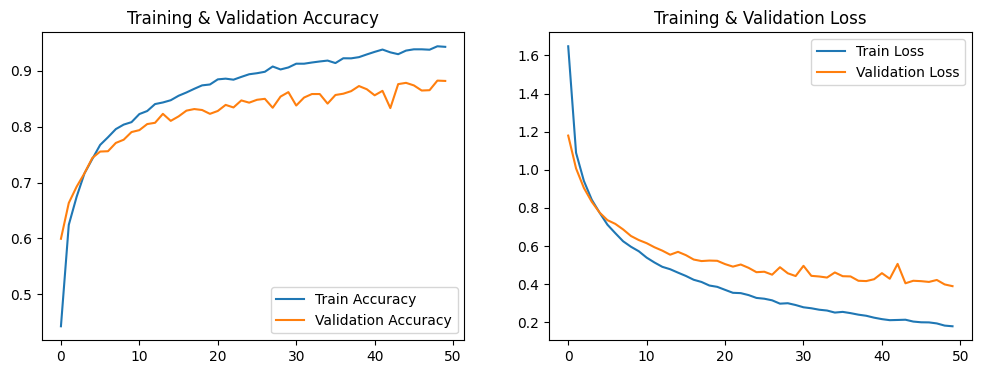

In [ ]:
# Evaluate model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot Training & Validation Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

# ====================================================
# Feature Extraction Function: Log-Mel + Tonnetz (TZ)
# ====================================================
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        if len(y) < 512:
            print(f"Skipping short file: {file_path}")
            return None

        # === Log-Mel Spectrogram ===
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[1], axis=1)
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[0], axis=0)

        # === Tonnetz ===
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(chroma=chroma, sr=sr)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[1], axis=1)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[0], axis=0)

        # Stack features
        mel_spec = np.expand_dims(mel_spec, axis=-1)
        tonnetz = np.expand_dims(tonnetz, axis=-1)
        combined = np.concatenate([mel_spec, tonnetz], axis=-1)

        if combined.shape != (128, 128, 2):
            print(f"Skipping due to unexpected shape: {combined.shape}")
            return None

        return combined

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# ====================================================
# Load Pre-trained ESC-50 Model (Sequential)
# ====================================================
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_TZ_ESC50.h5"
old_model = load_model(esc50_model_path)
print("Pre-trained ESC-50 model loaded successfully!")

# ====================================================
# Rebuild Sequential model without last layer
# ====================================================
model = Sequential()
for layer in old_model.layers[:-1]:  # Exclude last layer
    model.add(layer)

# Add new output layer for UrbanSound8K
model.add(tf.keras.layers.Dense(10, activation='softmax', name="urban_output"))

# ====================================================
# Load UrbanSound8K Metadata
# ====================================================
urbansound_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"
metadata = pd.read_csv(urbansound_csv_path)

# ====================================================
# Feature Extraction for UrbanSound8K
# ====================================================
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_name = metadata.loc[i, "slice_file_name"]
    folder = f"fold{metadata.loc[i, 'fold']}"
    file_path = os.path.join(urbansound_audio_dir, folder, file_name)
    label = metadata.loc[i, "classID"]

    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = to_categorical(y, num_classes=10)

print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")

# ====================================================
# Train-Test Split
# ====================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ====================================================
# Compile and Fine-tune the Model
# ====================================================
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# ====================================================
# Evaluate Model
# ====================================================
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# ====================================================
# Classification Report
# ====================================================
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:\n", report)

# ====================================================
# Save Fine-tuned Model
# ====================================================
urbansound_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_TZ_ESC50_UrbanSound8K.h5"
model.save(urbansound_model_path)
print("Fine-tuned UrbanSound8K model saved successfully!")

# ====================================================
# Save Training History as .npy
# ====================================================
result_path = "/content/drive/MyDrive/Colab Notebooks/Models/Result"
np.save(os.path.join(result_path, "cnn1_LM_TZ_train_acc.npy"), history.history['accuracy'])
np.save(os.path.join(result_path, "cnn1_LM_TZ_val_acc.npy"), history.history['val_accuracy'])
np.save(os.path.join(result_path, "cnn1_LM_TZ_train_loss.npy"), history.history['loss'])
np.save(os.path.join(result_path, "cnn1_LM_TZ_val_loss.npy"), history.history['val_loss'])

print("CNN1 training history saved!")


Pre-trained ESC-50 model loaded successfully!


  0%|          | 0/8732 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=876
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=438
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=219
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=110
  warnings.warn(
  0%|          | 9/8732 [00:03<55:22,  2.63it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=894
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=447

Feature shape: (8732, 128, 128, 2), Labels shape: (8732, 10)
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 139s 622ms/step - accuracy: 0.3325 - loss: 2.2174 - val_accuracy: 0.5965 - val_loss: 1.1651
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 138s 627ms/step - accuracy: 0.6201 - loss: 1.0993 - val_accuracy: 0.6760 - val_loss: 0.9831
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 134s 611ms/step - accuracy: 0.6857 - loss: 0.9209 - val_accuracy: 0.7075 - val_loss: 0.8869
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 132s 602ms/step - accuracy: 0.7184 - loss: 0.8422 - val_accuracy: 0.7321 - val_loss: 0.8129
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 129s 590ms/step - accuracy: 0.7465 - loss: 0.7611 - val_accuracy: 0.7642 - val_loss: 0.7463
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 152s 635ms/step - accuracy: 0.7694 - loss: 0.7000 - val_accuracy: 0.7710 - val_loss: 0.7043
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 136s 608ms/step - accuracy: 0.7794 - loss: 0.6715 - val_accuracy: 0.7888 - val_loss: 0.6790
Epoch 8/50
219/

Classification Report:
               precision    recall  f1-score   support

           0     0.8883    0.9015    0.8949       203
           1     0.8778    0.9186    0.8977        86
           2     0.7454    0.8798    0.8070       183
           3     0.9158    0.8657    0.8900       201
           4     0.9015    0.8883    0.8949       206
           5     0.9551    0.8808    0.9164       193
           6     0.9412    0.8889    0.9143        72
           7     0.9646    0.9183    0.9409       208
           8     0.9006    0.8788    0.8896       165
           9     0.8439    0.8696    0.8565       230

    accuracy                         0.8872      1747
   macro avg     0.8934    0.8890    0.8902      1747
weighted avg     0.8915    0.8872    0.8884      1747

Fine-tuned UrbanSound8K model saved successfully!
CNN1 training history saved!


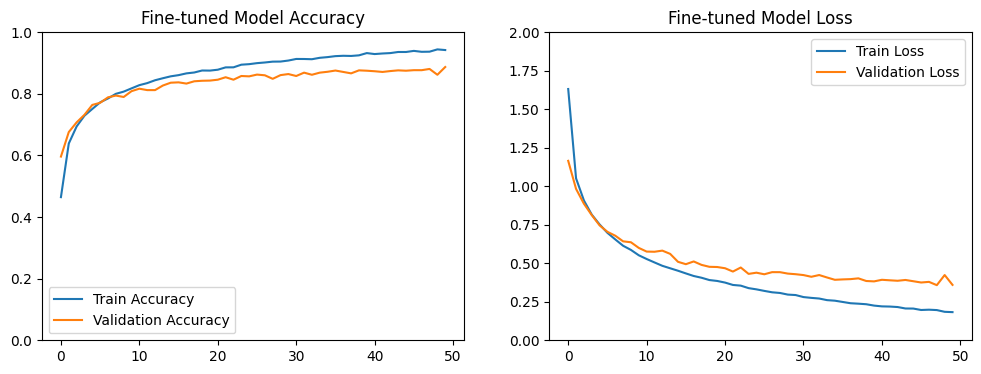

CNN1 training history saved!


In [ ]:
# Plot training history with customized y-axis ranges
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0, 1)  # Set y-axis range for accuracy
plt.legend()
plt.title('Fine-tuned Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 2)  # Set y-axis range for loss
plt.legend()
plt.title('Fine-tuned Model Loss')

plt.show()


# SAVE CNN1 HISTORY AFTER TRAINING
import numpy as np

np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn1_LM_TZ_train_acc.npy", history.history['accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn1_LM_TZ_val_acc.npy", history.history['val_accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn1_LM_TZ_train_loss.npy", history.history['loss'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn1_LM_TZ_val_loss.npy", history.history['val_loss'])

print("CNN1 training history saved!")